In [2]:
import xarray as xr
import numpy as np
import xgcm
import xmitgcm
from matplotlib import pyplot as plt
%matplotlib inline
import os
#plt.rcParams['figure.figsize'] = (12,6)
import glob
import ecco_v4_py as ecco
from matplotlib import cm
import xrft
#from MITgcmutils import mds
import xesmf as xe
import scicomap as sc
import cmocean
import pandas as pd
import pyinterp
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import pyinterp
from matplotlib.colors import LightSource
from matplotlib import cbook,cm
import matplotlib.colors as colors



mesh = pyinterp.RTree()

div_map = sc.ScicoMiscellaneous(cmap='rainbow-kov')
div_map.unif_sym_cmap(lift=10, bitonic=False, diffuse=True)
fixed_cmap = div_map.get_mpl_color_map()

tp = '>f4'

output_dir = '../input/'

llc540_extra_metadata = xmitgcm.utils.get_extra_metadata(domain='llc', nx=540)

# Then we read the grid from the input files
grid = xmitgcm.utils.get_grid_from_input('../run/tile<NFACET>.mitgrid',
                                         geometry='llc',
                                         extra_metadata=llc540_extra_metadata)


# define the connectivity between faces
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}



In [3]:
files = sorted(glob.glob('../runptracer/Diags2/tracers*.data'))
filenumbers=[]
for i in files:
    filenumbers.append(int(i[-15:-5]))


In [5]:
len(filenumbers)

31

In [6]:
ds = xmitgcm.open_mdsdataset(data_dir='../runptracer/Diags2/',grid_dir='../runptracer/',
                             prefix=['tracers'],iters=filenumbers,
                             delta_t=500, geometry='llc',extra_metadata=llc540_extra_metadata)

ds['time'] = ('time', ds.time.values+np.datetime64('2037-12-31 12:00:00') )

In [8]:
def interp_kernal(ds,varname,itime):

    #global
    lon016 = [-180.,180.]
    lat016 = [-75., 70.]
    res = 1/6
    mx, my = np.meshgrid(np.arange(lon016[0],lon016[1],res),np.arange(lat016[0],lat016[1],res), indexing='ij')

    #print(itime)
    # interp
    #indices = slice(0,None,8)

    lons = ds['XC']
    lats = ds['YC']
    data3dcache = np.zeros( [ds.Z.shape[0], mx.shape[1], mx.shape[0] ] )
    
    for k in range(ds.Z.shape[0]):
        values = ds[varname][itime,k].values.ravel()
        values[values==0]=np.nan
        mesh.packing(np.vstack((lons.values.ravel(), lats.values.ravel())).T, values )
    
        idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((mx.ravel(), my.ravel())).T,
            within=True,  # Extrapolation is forbidden
            radius=40000,  # In a radius of 5.5 Km
            k=8,  # We are looking for at most 8 neighbours
            num_threads=0)
        idw_eta = idw_eta.reshape(mx.shape)
        idw_eta[idw_eta==0]=np.nan

        data3dcache[k,:,:] = idw_eta.T
    data3dcache = xr.DataArray(data3dcache, coords={"time":ds.time[itime].values,"Z": ds.Z.values,
                                                                 "lat": my[0, :], "lon": mx[:, 0]},
                              dims=["Z","lat", "lon"]).astype('float32')
    datetoday = pd.to_datetime(data3dcache.time.values).year*10000+pd.to_datetime(data3dcache.time.values).month*100+pd.to_datetime(data3dcache.time.values).day
    print(                outdir+varname+'.'+str(int(datetoday))+'.nc')
    data3dcache.to_netcdf(outdir+varname+'.'+str(int(datetoday))+'.nc')
    
    return data3dcache


def interp_2d_dataarray(ds,outdir,varname,itime,Z,lon016,lat016,res):
    
    mx, my = np.meshgrid(np.arange(lon016[0],lon016[1],res),np.arange(lat016[0],lat016[1],res), indexing='ij')
    
    lons = ds['XC']
    lats = ds['YC']
    data3dcache = np.zeros( [ds.shape[1], mx.shape[1], mx.shape[0] ]  )
    dsuse = ds.load()
    values = dsuse.values.ravel()
    #mask = ds.maskC[0].values.ravel()
    values[values==0]=np.nan
    mesh.packing(np.vstack((lons.values.ravel(), lats.values.ravel())).T, values )
    
    idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((mx.ravel(), my.ravel())).T,
            within=True,  # Extrapolation is forbidden
            radius=40000,  # In a radius of 5.5 Km
            k=8,  # We are looking for at most 8 neighbours
            num_threads=0)
    idw_eta = idw_eta.reshape(mx.shape)
    idw_eta[idw_eta==0]=np.nan
    #data3dcache = xr.DataArray(idw_eta.T, coords={"time":ds.time[itime].values,
    #                                                             "lat": my[0, :], "lon": mx[:, 0]},
    #                          dims=["lat", "lon"]).astype('float32')
    data3dcache = xr.DataArray(idw_eta.T, coords={"lat": my[0, :], "lon": mx[:, 0]},
                              dims=["lat", "lon"]).astype('float32')
    #datetoday = pd.to_datetime(data3dcache.time.values).year*10000+pd.to_datetime(data3dcache.time.values).month*100+pd.to_datetime(data3dcache.time.values).day
    datetoday = 1
    print(                outdir+varname+'.'+str(int(datetoday))+'.nc')
    data3dcache.to_netcdf(outdir+varname+'.'+str(int(datetoday))+'.nc')
    
    return data3dcache

def interp_kernal_dataarray(ds,outdir,varname,itime,Z,lon016,lat016,res):
    
    #global
    #lon016 = [-180.,180.]
    #lat016 = [-75., 70.]
    #res = 1/6
    mx, my = np.meshgrid(np.arange(lon016[0],lon016[1],res),np.arange(lat016[0],lat016[1],res), indexing='ij')

    #print(itime)
    # interp
    #indices = slice(0,None,8)

    lons = ds['XC']
    lats = ds['YC']
    data3dcache = np.zeros( [ds.shape[1], mx.shape[1], mx.shape[0] ]  )
    dsuse = ds[itime].load()
    for k in range(ds.k.shape[0]):
        values = dsuse[k].values.ravel()
        mask = ds.maskC[k].values.ravel()
        values[mask==0]=np.nan
        mesh.packing(np.vstack((lons.values.ravel(), lats.values.ravel())).T, values )
    
        idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((mx.ravel(), my.ravel())).T,
            within=True,  # Extrapolation is forbidden
            radius=40000,  # In a radius of 5.5 Km
            k=8,  # We are looking for at most 8 neighbours
            num_threads=0)
        idw_eta = idw_eta.reshape(mx.shape)
        idw_eta[idw_eta==0]=np.nan

        data3dcache[k,:,:] = idw_eta.T
    data3dcache = xr.DataArray(data3dcache, coords={"time":ds.time[itime].values,"Z": Z,
                                                                 "lat": my[0, :], "lon": mx[:, 0]},
                              dims=["Z","lat", "lon"]).astype('float32')
  
    datetoday = pd.to_datetime(data3dcache.time.values).year*10000+pd.to_datetime(data3dcache.time.values).month*100+pd.to_datetime(data3dcache.time.values).day
    print(                outdir+varname+'.'+str(int(datetoday))+'.nc')
    data3dcache.to_netcdf(outdir+varname+'.'+str(int(datetoday))+'.nc')
    
    return data3dcache


In [10]:
varname = 'TRAC01'
varname_out = 'TRAC07'

outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(31):
    print(itime)
    interp_kernal_dataarray(ds[varname],outdir,varname_out,itime,ds.Z.values,lon016,lat016,res)

0
./tracers/TRAC07.20891228.nc
1
./tracers/TRAC07.20900626.nc
2
./tracers/TRAC07.20901223.nc
3
./tracers/TRAC07.20910621.nc
4
./tracers/TRAC07.20911218.nc
5
./tracers/TRAC07.20920615.nc
6
./tracers/TRAC07.20921212.nc
7
./tracers/TRAC07.20930610.nc
8
./tracers/TRAC07.20931207.nc
9
./tracers/TRAC07.20940605.nc
10
./tracers/TRAC07.20941202.nc
11
./tracers/TRAC07.20950531.nc
12
./tracers/TRAC07.20951127.nc
13
./tracers/TRAC07.20960525.nc
14
./tracers/TRAC07.20961121.nc
15
./tracers/TRAC07.20970520.nc
16
./tracers/TRAC07.20971116.nc
17
./tracers/TRAC07.20980515.nc
18
./tracers/TRAC07.20981111.nc
19
./tracers/TRAC07.20990510.nc
20
./tracers/TRAC07.20991106.nc
21
./tracers/TRAC07.21000505.nc
22
./tracers/TRAC07.21001101.nc
23
./tracers/TRAC07.21010430.nc
24
./tracers/TRAC07.21011027.nc
25
./tracers/TRAC07.21020425.nc
26
./tracers/TRAC07.21021022.nc
27
./tracers/TRAC07.21030420.nc
28
./tracers/TRAC07.21031017.nc
29
./tracers/TRAC07.21040414.nc
30
./tracers/TRAC07.21041011.nc


In [11]:
varname = 'TRAC02'
varname_out = 'TRAC08'

outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(31):
    print(itime)
    interp_kernal_dataarray(ds[varname],outdir,varname_out,itime,ds.Z.values,lon016,lat016,res)

0
./tracers/TRAC08.20891228.nc
1
./tracers/TRAC08.20900626.nc
2
./tracers/TRAC08.20901223.nc
3
./tracers/TRAC08.20910621.nc
4
./tracers/TRAC08.20911218.nc
5
./tracers/TRAC08.20920615.nc
6
./tracers/TRAC08.20921212.nc
7
./tracers/TRAC08.20930610.nc
8
./tracers/TRAC08.20931207.nc
9
./tracers/TRAC08.20940605.nc
10
./tracers/TRAC08.20941202.nc
11
./tracers/TRAC08.20950531.nc
12
./tracers/TRAC08.20951127.nc
13
./tracers/TRAC08.20960525.nc
14
./tracers/TRAC08.20961121.nc
15
./tracers/TRAC08.20970520.nc
16
./tracers/TRAC08.20971116.nc
17
./tracers/TRAC08.20980515.nc
18
./tracers/TRAC08.20981111.nc
19
./tracers/TRAC08.20990510.nc
20
./tracers/TRAC08.20991106.nc
21
./tracers/TRAC08.21000505.nc
22
./tracers/TRAC08.21001101.nc
23
./tracers/TRAC08.21010430.nc
24
./tracers/TRAC08.21011027.nc
25
./tracers/TRAC08.21020425.nc
26
./tracers/TRAC08.21021022.nc
27
./tracers/TRAC08.21030420.nc
28
./tracers/TRAC08.21031017.nc
29
./tracers/TRAC08.21040414.nc
30
./tracers/TRAC08.21041011.nc


In [79]:
itime = 20
varname = 'Depth'
outdir = './'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
tracer_depth = interp_2d_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)


./Depth.1.nc


In [80]:
itime = 20
varname = 'TRAC01'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
data3dcache = interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC01.20991106.nc


In [114]:
varname = 'TRAC01'

outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(23,31):
    interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC01.21010430.nc
./tracers/TRAC01.21011027.nc
./tracers/TRAC01.21020425.nc
./tracers/TRAC01.21021022.nc
./tracers/TRAC01.21030420.nc
./tracers/TRAC01.21031017.nc
./tracers/TRAC01.21040414.nc
./tracers/TRAC01.21041011.nc


In [81]:
itime = 20
varname = 'TRAC02'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
data3dcache = interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC02.20991106.nc


In [115]:
varname = 'TRAC02'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(23,31):
    interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC02.21010430.nc
./tracers/TRAC02.21011027.nc
./tracers/TRAC02.21020425.nc
./tracers/TRAC02.21021022.nc
./tracers/TRAC02.21030420.nc
./tracers/TRAC02.21031017.nc
./tracers/TRAC02.21040414.nc
./tracers/TRAC02.21041011.nc


In [82]:
itime = 20
varname = 'TRAC03'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
data3dcache = interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC03.20991106.nc


In [116]:
varname = 'TRAC03'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(23,31):
    interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC03.21010430.nc
./tracers/TRAC03.21011027.nc
./tracers/TRAC03.21020425.nc
./tracers/TRAC03.21021022.nc
./tracers/TRAC03.21030420.nc
./tracers/TRAC03.21031017.nc
./tracers/TRAC03.21040414.nc
./tracers/TRAC03.21041011.nc


In [83]:
itime = 20
varname = 'TRAC04'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
data3dcache = interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC04.20991106.nc


In [117]:
varname = 'TRAC04'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(23,31):
    interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC04.21010430.nc
./tracers/TRAC04.21011027.nc
./tracers/TRAC04.21020425.nc
./tracers/TRAC04.21021022.nc
./tracers/TRAC04.21030420.nc
./tracers/TRAC04.21031017.nc
./tracers/TRAC04.21040414.nc
./tracers/TRAC04.21041011.nc


In [84]:
itime = 20
varname = 'TRAC05'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
data3dcache = interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC05.20991106.nc


In [118]:
varname = 'TRAC05'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(23,31):
    interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC05.21010430.nc
./tracers/TRAC05.21011027.nc
./tracers/TRAC05.21020425.nc
./tracers/TRAC05.21021022.nc
./tracers/TRAC05.21030420.nc
./tracers/TRAC05.21031017.nc
./tracers/TRAC05.21040414.nc
./tracers/TRAC05.21041011.nc


In [85]:
itime = 20
varname = 'TRAC06'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
data3dcache = interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC06.20991106.nc


In [119]:
varname = 'TRAC06'
outdir = './tracers/'
lon016 = [35,105]
lat016 = [-50,20]
res = 1./6
for itime in range(23,31):
    interp_kernal_dataarray(ds[varname],outdir,varname,itime,ds.Z.values,lon016,lat016,res)

./tracers/TRAC06.21010430.nc
./tracers/TRAC06.21011027.nc
./tracers/TRAC06.21020425.nc
./tracers/TRAC06.21021022.nc
./tracers/TRAC06.21030420.nc
./tracers/TRAC06.21031017.nc
./tracers/TRAC06.21040414.nc
./tracers/TRAC06.21041011.nc


In [3]:
outdir = './tracers/'

files = sorted( glob.glob(outdir+'/TRAC01.*.nc') )
trac01 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )

files = sorted( glob.glob(outdir+'/TRAC02.*.nc') )
trac02 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )

files = sorted( glob.glob(outdir+'/TRAC03.*.nc') )
trac03 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )

files = sorted( glob.glob(outdir+'/TRAC04.*.nc') )
trac04 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )


files = sorted( glob.glob(outdir+'/TRAC05.*.nc') )
trac05 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )

files = sorted( glob.glob(outdir+'/TRAC06.*.nc') )
trac06 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )



In [12]:

files = sorted( glob.glob(outdir+'/TRAC07.*.nc') )
trac07 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )

files = sorted( glob.glob(outdir+'/TRAC08.*.nc') )
trac08 = xr.open_mfdataset(files,concat_dim='time',combine='nested' )


In [27]:
import xarray as xr
import glob

# 站点名称，每个 tracer 对应一个 site
site_mapping = {
    "TRAC01": "Longqi",
    "TRAC02": "Onnuri",
    "TRAC03": "Tiancheng",
    "TRAC04": "Wocan",
    "TRAC05": "Solitaire",
    "TRAC06": "Kairei"
}

tracer_types = list(site_mapping.keys())
outdir = './tracers/'

datasets = []
for tracer in tracer_types:
    files = sorted(glob.glob(outdir + f'/{tracer}.*.nc'))
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')

    # 扩展 site 维度
    ds = ds.expand_dims(dim="site")  

    # 直接用 DataArray 赋值，确保它不是标量
    ds = ds.assign_coords({"site": xr.DataArray([site_mapping[tracer]], dims=["site"])})

    datasets.append(ds)

# 合并所有数据集
tracers_combined = xr.concat(datasets, dim="site")

# 保存合并后的数据集
tracers_combined.to_netcdf("tracers_combined.nc")

print(tracers_combined)


In [13]:

import xarray as xr
import glob

# 站点名称，每个 tracer 对应一个 site
site_mapping = {
    "TRAC07": "NewSite1",
    "TRAC08": "NewSite2",
}

tracer_types = list(site_mapping.keys())
outdir = './tracers/'

datasets = []
for tracer in tracer_types:
    files = sorted(glob.glob(outdir + f'/{tracer}.*.nc'))
    ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')

    # 扩展 site 维度
    ds = ds.expand_dims(dim="site")  

    # 直接用 DataArray 赋值，确保它不是标量
    ds = ds.assign_coords({"site": xr.DataArray([site_mapping[tracer]], dims=["site"])})

    datasets.append(ds)

# 合并所有数据集
tracers_combined = xr.concat(datasets, dim="site")

# 保存合并后的数据集
tracers_combined.to_netcdf("newsite_tracers_combined.nc")

print(tracers_combined)


<xarray.Dataset> Size: 3GB
Dimensions:                        (site: 2, time: 31, Z: 63, lat: 420, lon: 420)
Coordinates:
  * time                           (time) datetime64[ns] 248B 2089-12-28T12:0...
  * Z                              (Z) float32 252B -0.5 -1.5 ... -5.906e+03
  * lat                            (lat) float64 3kB -50.0 -49.83 ... 19.83
  * lon                            (lon) float64 3kB 35.0 35.17 ... 104.7 104.8
  * site                           (site) <U8 64B 'NewSite1' 'NewSite2'
Data variables:
    __xarray_dataarray_variable__  (site, time, Z, lat, lon) float32 3GB dask.array<chunksize=(1, 1, 63, 420, 420), meta=np.ndarray>


In [29]:
tracers_combined.__xarray_dataarray_variable__.shape

(2, 31, 63, 420, 420)

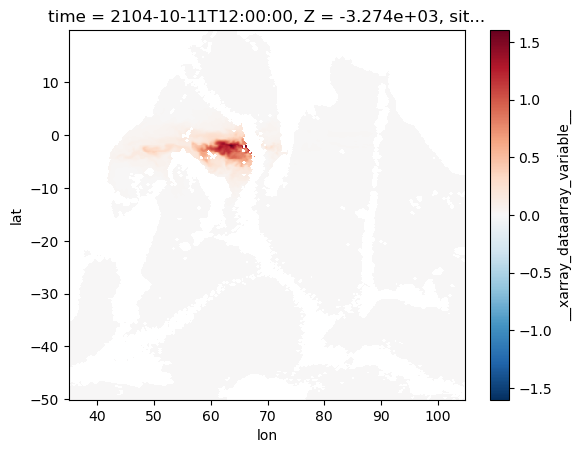

In [54]:
tracers_combined.__xarray_dataarray_variable__[0,-1,55].plot()

In [ ]:
station_names = ["Longqi", "Tiancheng", "Kairei", "Solitaire", "Onnuri", "Wocan"]
tracer_types = ["trac01", "trac03", "trac06", "trac05", "trac02", "trac04"]


In [4]:
#site    = ['Solitaire',      'Wocan',      'Kairei',   'Onnuri',     'Tiancheng',    'Duanqiao',       'Longqi']
#lonall    = np.array([ 65.848167,     60.505555,    70.040333, 66.42366666666666,   63.92166666666667,   50.4, 49.64938333333333] )
#latall    = np.array([-19.556833,      6.376666,   -25.320500, -11.414666666666667, -27.85,  -37.65,  -37.78378333333333 ]  )
#kall    = [22, 28, 37]

site    = ['Solitaire',      'Wocan',      'Kairei',   'Onnuri',     'Tiancheng',          'Longqi']
lonall    = np.array([ 65.848167,     60.505555,    70.040333, 66.42366666666666,   63.92166666666667,    49.64938333333333] )
latall    = np.array([-19.556833,      6.376666,   -25.320500, -11.414666666666667, -27.85,    -37.78378333333333 ]  )
#kall    = [22, 28, 37]
topo540 = xr.open_dataarray( 'Depth.20850101.nc' )
topo_tracer = xr.open_dataarray( 'Depth.1.nc' )


In [5]:
tracers_datas = np.zeros([6,6,31,63])
inorthwrad=[5,4,2,0,3,1]
for i in range(6):
    tracers_datas[0,i] = trac01.__xarray_dataarray_variable__.sel(lon=lonall[inorthwrad[i]],lat=latall[inorthwrad[i]],method='nearest').values
    tracers_datas[1,i] = trac03.__xarray_dataarray_variable__.sel(lon=lonall[inorthwrad[i]],lat=latall[inorthwrad[i]],method='nearest').values
    tracers_datas[2,i] = trac06.__xarray_dataarray_variable__.sel(lon=lonall[inorthwrad[i]],lat=latall[inorthwrad[i]],method='nearest').values
    tracers_datas[3,i] = trac05.__xarray_dataarray_variable__.sel(lon=lonall[inorthwrad[i]],lat=latall[inorthwrad[i]],method='nearest').values
    tracers_datas[4,i] = trac02.__xarray_dataarray_variable__.sel(lon=lonall[inorthwrad[i]],lat=latall[inorthwrad[i]],method='nearest').values
    tracers_datas[5,i] = trac04.__xarray_dataarray_variable__.sel(lon=lonall[inorthwrad[i]],lat=latall[inorthwrad[i]],method='nearest').values
    

In [21]:
import xarray as xr
import numpy as np

# 假设你的时间坐标和深度坐标

time = np.arange(0,15.5,0.5)  # 31 个时间步
depth = trac01.Z.values   # 63 个深度层
#station_names = ["Solitaire", "Wocan", "Kairei", "Onnuri", "Tiancheng", "Longqi"]
station_names = ["Longqi", "Tiancheng", "Kairei", "Solitaire", "Onnuri", "Wocan"]
tracer_types = ["trac01", "trac03", "trac06", "trac05", "trac02", "trac04"]

# 构建 xarray DataArray
tracers_xr = xr.DataArray(
    tracers_datas,
    dims=["tracer", "station", "time", "depth"],
    coords={
        "tracer": tracer_types,
        "station": station_names,
        "time": time,
        "depth": depth
    }
)

# 添加属性
tracers_xr.attrs["description"] = "Tracer data across stations over time and depth"

tracers_xr.to_netcdf('tracers_at6Stations.nc')

/tmp/ipykernel_371029/2619233248.py:11: RuntimeWarning: divide by zero encountered in log10
  cs = axs[i,j].contourf(tt,zz/1e3,np.log10(tracers_xr.values[j,i].T),levels=np.arange(1,7,1),cmap=cmaps[j] )
/tmp/ipykernel_371029/2619233248.py:11: RuntimeWarning: invalid value encountered in log10
  cs = axs[i,j].contourf(tt,zz/1e3,np.log10(tracers_xr.values[j,i].T),levels=np.arange(1,7,1),cmap=cmaps[j] )


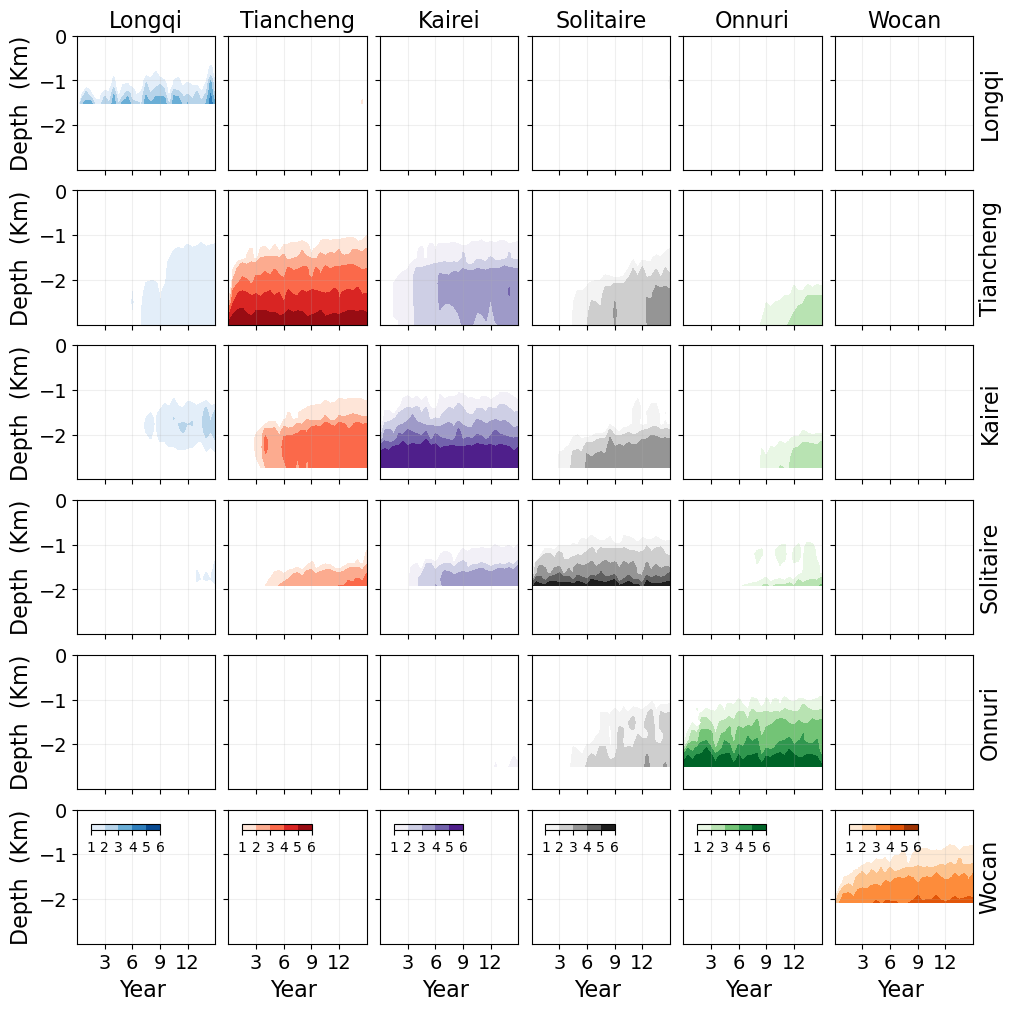

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

tt = np.arange(0,15.5,0.5)
zz = trac01.Z.values 
cmaps = ['Blues','Reds','Purples','Greys','Greens','Oranges']
fig, axs = plt.subplots(6,6,constrained_layout=True,sharex=True,sharey=True,figsize=(10,10))
for j in range(6):
    for i in range(6):   
        axs[i,j].tick_params(labelsize=14)
        
        cs = axs[i,j].contourf(tt,zz/1e3,np.log10(tracers_xr.values[j,i].T),levels=np.arange(1,7,1),cmap=cmaps[j] )
        
        if i==0:
            axs[i,j].set_title(tracers_xr.station.values[j],fontsize=16)
        
        axs[i,j].set_ylim(-3,0)
        axs[i,j].set_xticks([3,6,9,12])
        axs[i,j].set_yticks([-2,-1,0])
        axs[i,j].grid(True,alpha=0.2)
        
        if j==0:
            axs[i,j].set_ylabel('Depth  (Km)',fontsize=16)
            
        if j==5:
            axs[i,j].yaxis.set_label_position("right")
            axs[i,j].set_ylabel(tracers_xr.station[i].values,fontsize=16)
        if i==5:
            #cbaxes = fig.add_axes(ax=axs[i,j])  
            axs[i,j].set_xlabel('Year ',fontsize=16)
            cax = inset_axes(axs[i, j], width="50%", height="5%", loc='upper left', borderpad=1)
            fig.colorbar(cs,ax=axs[i,j],orientation='horizontal', cax=cax )#fraction=0.05, pad=0.1)  


/tmp/ipykernel_84883/1999306434.py:11: RuntimeWarning: divide by zero encountered in log10
  cs = axs[i,j].contourf(tt,zz/1e3,np.log10(tracers_datas[j,i].T),levels=np.arange(1,7,1),cmap=cmaps[j] )
/tmp/ipykernel_84883/1999306434.py:11: RuntimeWarning: invalid value encountered in log10
  cs = axs[i,j].contourf(tt,zz/1e3,np.log10(tracers_datas[j,i].T),levels=np.arange(1,7,1),cmap=cmaps[j] )


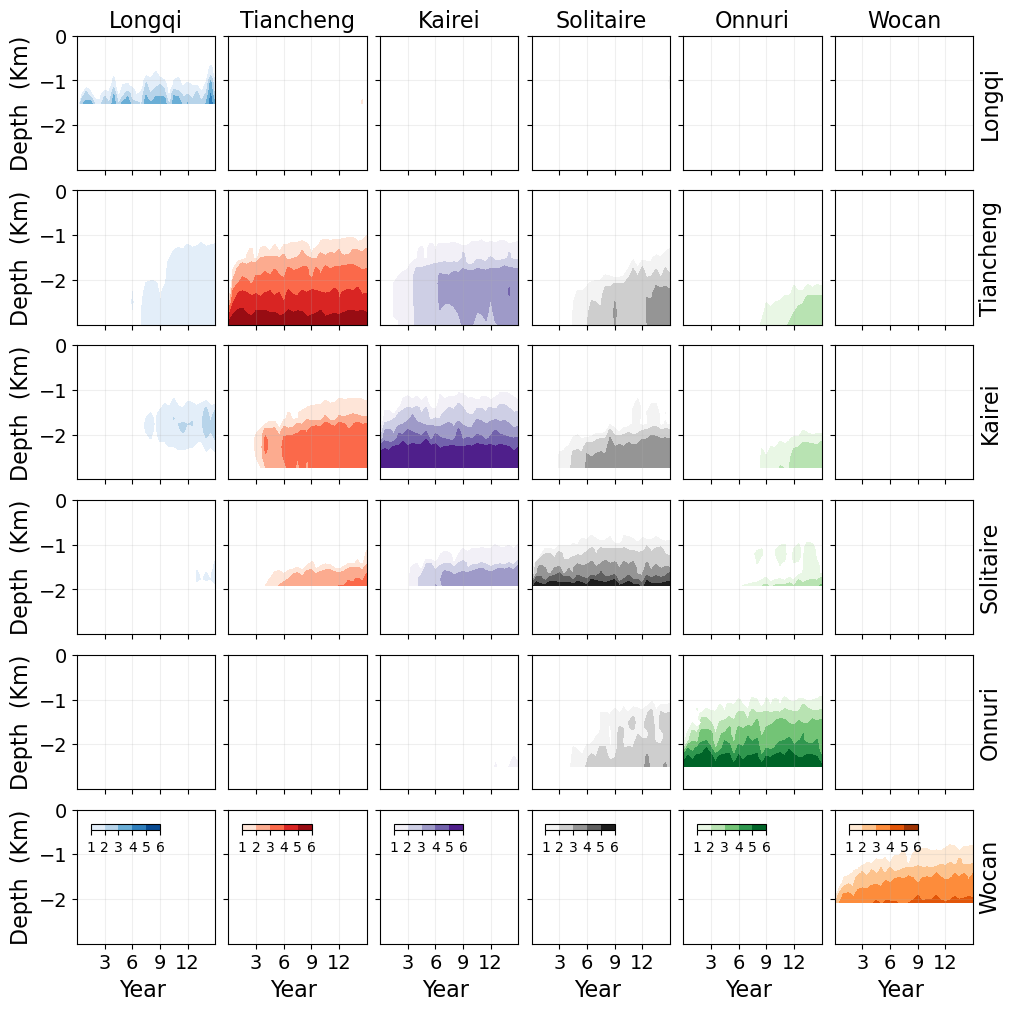

In [190]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

tt = np.arange(0,15.5,0.5)
zz = trac01.Z.values 
cmaps = ['Blues','Reds','Purples','Greys','Greens','Oranges']
fig, axs = plt.subplots(6,6,constrained_layout=True,sharex=True,sharey=True,figsize=(10,10))
for j in range(6):
    for i in range(6):   
        axs[i,j].tick_params(labelsize=14)
        
        cs = axs[i,j].contourf(tt,zz/1e3,np.log10(tracers_datas[j,i].T),levels=np.arange(1,7,1),cmap=cmaps[j] )
        
        if i==0:
            axs[i,j].set_title(site[inorthwrad[j]],fontsize=16)
        
        axs[i,j].set_ylim(-3,0)
        axs[i,j].set_xticks([3,6,9,12])
        axs[i,j].set_yticks([-2,-1,0])
        axs[i,j].grid(True,alpha=0.2)
        
        if j==0:
            axs[i,j].set_ylabel('Depth  (Km)',fontsize=16)
            
        if j==5:
            axs[i,j].yaxis.set_label_position("right")
            axs[i,j].set_ylabel(site[inorthwrad[i]],fontsize=16)
        if i==5:
            #cbaxes = fig.add_axes(ax=axs[i,j])  
            axs[i,j].set_xlabel('Year ',fontsize=16)
            cax = inset_axes(axs[i, j], width="50%", height="5%", loc='upper left', borderpad=1)
            fig.colorbar(cs,ax=axs[i,j],orientation='horizontal', cax=cax )#fraction=0.05, pad=0.1)  

plt.savefig('allsites_tracers.pdf', format='pdf', dpi=1000)



In [1]:
!du -h --max-depth=1 ./tracers


7.8G	./tracers


In [ ]:
!tar -czvf folder.tar.gz folder/

In [185]:
topo_tracer.sel(lon=lonall[5], lat=latall[5],method='nearest').values

array(2330.4126, dtype=float32)

/tmp/ipykernel_328786/3251262431.py:3: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[-1,52].values),
/tmp/ipykernel_328786/3251262431.py:5: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[-1,52].values),
/tmp/ipykernel_328786/3251262431.py:7: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[-1,52].values),
/tmp/ipykernel_328786/3251262431.py:9: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[-1,52].values),
/tmp/ipykernel_328786/3251262431.py:26: UserWarning: The following kwargs were not used by contour: 'linestyle'
  plt.contourf(topo540.lon,topo540.lat,-topo540,levels=np.arange(-10

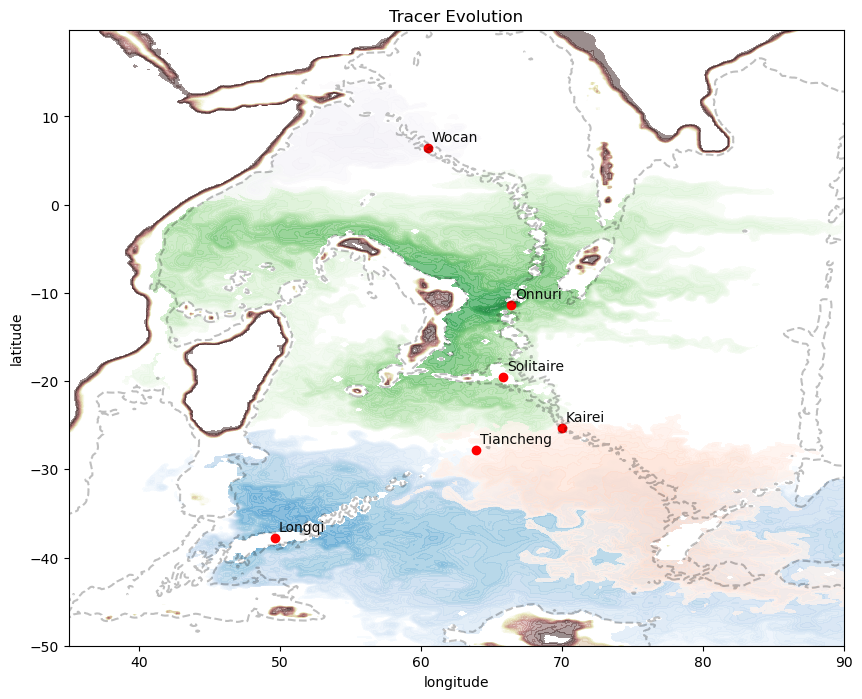

In [188]:
fig=plt.figure(figsize=(10, 8))
# use contour with 'lons' and 'lats' for the plot x and y axes
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[-1,52].values), 
             cmap='Blues',alpha=0.75,levels=np.arange(1,6.1,0.1))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[-1,52].values), 
             cmap='Greens',alpha=0.75,levels=np.arange(1,6.1,0.1))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[-1,52].values), 
             cmap='Reds',alpha=0.75,levels=np.arange(0,6.1,0.1))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[-1,52].values), 
             cmap='Purples',alpha=0.75,levels=np.arange(1,6.1,0.1))
plt.title('Tracer Evolution')

plt.xlim(np.nanmin(trac01.lon.values), 90.)
plt.ylim(np.nanmin(trac01.lat.values), np.nanmax(trac01.lat.values))

plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.colorbar()

plt.scatter(lonall, latall, c='r')
for i in range(6):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )

plt.contour(topo540.lon,topo540.lat,-topo540,levels=[-3000],colors='k',alpha=0.25)
#plt.contour(topo540.lon,topo540.lat,topo540,levels=[20],colors='k',alpha=0.25)
plt.contourf(topo540.lon,topo540.lat,-topo540,levels=np.arange(-1000,0,50),cmap=cm.pink_r,alpha=0.5,linestyle='None')

In [98]:
str( trac01.time[0].values )[0:7]

'2089-12'

/tmp/ipykernel_84883/2251998347.py:5: RuntimeWarning: invalid value encountered in log10
  ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[tt,kk].values),
/tmp/ipykernel_84883/2251998347.py:7: RuntimeWarning: invalid value encountered in log10
  ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[tt,kk].values),
/tmp/ipykernel_84883/2251998347.py:9: RuntimeWarning: invalid value encountered in log10
  ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[tt,kk].values),
/tmp/ipykernel_84883/2251998347.py:11: RuntimeWarning: invalid value encountered in log10
  ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[tt,kk].values),
/tmp/ipykernel_84883/2251998347.py:13: RuntimeWarning: invalid value encountered in log10
  ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac05.__xarray_dataarray_variable__

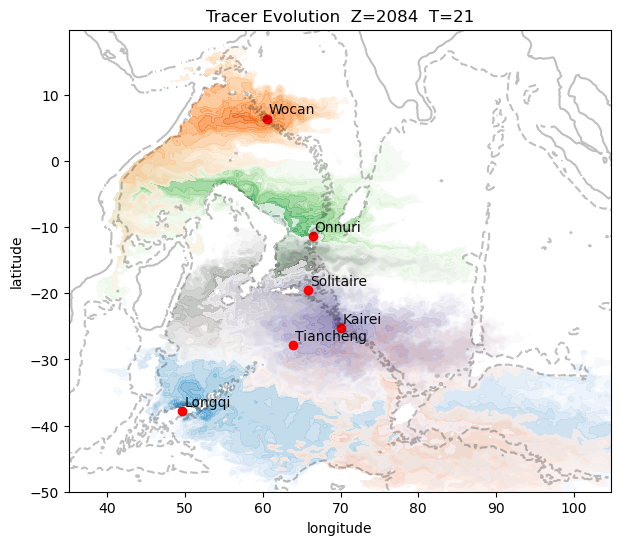

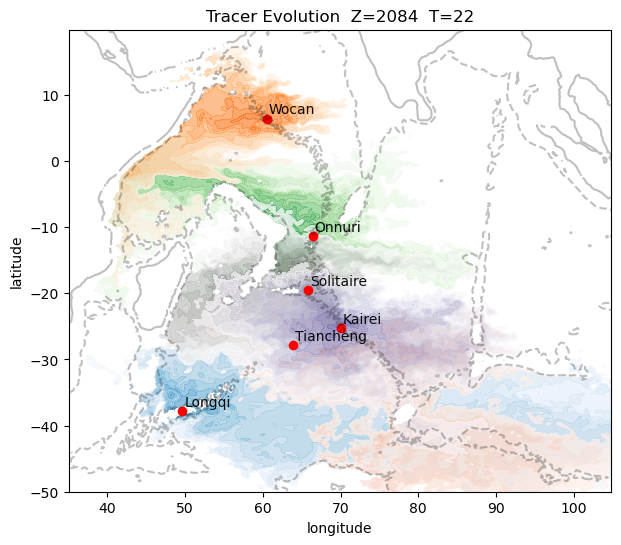

In [111]:
kk = 50
for tt in range(21,23):
    fig,ax =plt.subplots(1,1,figsize=(7, 6))
    # use contour with 'lons' and 'lats' for the plot x and y axes
    ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[tt,kk].values), 
             cmap='Blues',alpha=0.7,levels=np.arange(2,6.25,0.25))
    ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[tt,kk].values), 
             cmap='Greens',alpha=0.7,levels=np.arange(2,6.25,0.25))
    ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[tt,kk].values), 
             cmap='Reds',alpha=0.7,levels=np.arange(2,6.25,0.25))
    ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[tt,kk].values), 
             cmap='Oranges',alpha=0.7,levels=np.arange(2,6.25,0.25))
    ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac05.__xarray_dataarray_variable__[tt,kk].values), 
             cmap='Greys',alpha=0.7,levels=np.arange(2,6.25,0.25))
    ax.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac06.__xarray_dataarray_variable__[tt,kk].values), 
             cmap='Purples',alpha=0.7,levels=np.arange(2,6.25,0.25))
    ax.set_title('Tracer Evolution' + '  Z='+str(int(-trac01.Z[kk].values))+'  T='+str(tt) )

    ax.set_xlim(np.nanmin(trac01.lon.values), np.nanmax(trac01.lon.values))
    ax.set_ylim(np.nanmin(trac01.lat.values), np.nanmax(trac01.lat.values))

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    #plt.colorbar()

    ax.scatter(lonall, latall, c='r')
    for i in range(6):
        ax.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )

    ax.contour(topo540.lon,topo540.lat,-topo540,levels=[-3000],colors='k',alpha=0.25)
    ax.contour(topo540.lon,topo540.lat,topo540,levels=[20],colors='k',alpha=0.25)
   
    if tt<10:
        fig.savefig('tracer_0'+str(int(tt))+'Z'+str(int(-trac01.Z[kk].values))+'.png',dpi=1000)
    else:
        fig.savefig('tracer_'+str(int(tt))+'Z'+str(int(-trac01.Z[kk].values))+'.png',dpi=1000)




In [95]:
png_gif('tracer_*Z2729*.png','tracer_Z2729.gif')


In [96]:
png_gif('tracer_*Z2084*.png','tracer_Z2084.gif')

In [103]:
png_gif('tracer_*Z2990*.png','tracer_Z2990.gif')

/tmp/ipykernel_84883/3174568045.py:5: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[yy,50].values),
/tmp/ipykernel_84883/3174568045.py:7: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[yy,50].values),
/tmp/ipykernel_84883/3174568045.py:9: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[yy,50].values),
/tmp/ipykernel_84883/3174568045.py:11: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[yy,50].values),
/tmp/ipykernel_84883/3174568045.py:13: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac05.__xarray_dataarray_varia

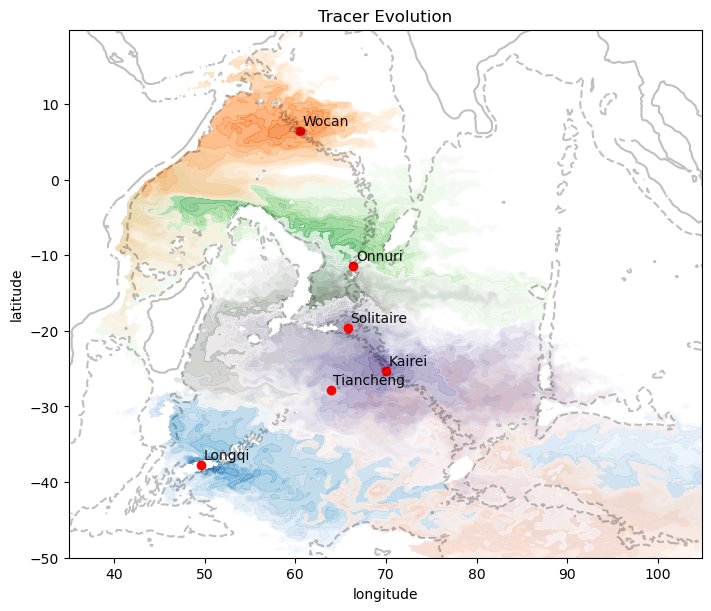

In [123]:
yy = -7

fig=plt.figure(figsize=(7, 6),constrained_layout=True)
# use contour with 'lons' and 'lats' for the plot x and y axes
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[yy,50].values), 
             cmap='Blues',alpha=0.7,levels=np.arange(2,6.25,0.25))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[yy,50].values), 
             cmap='Greens',alpha=0.7,levels=np.arange(2,6.25,0.25))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[yy,50].values), 
             cmap='Reds',alpha=0.7,levels=np.arange(2,6.25,0.25))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[yy,50].values), 
             cmap='Oranges',alpha=0.7,levels=np.arange(2,6.25,0.25))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac05.__xarray_dataarray_variable__[yy,50].values), 
             cmap='Greys',alpha=0.7,levels=np.arange(2,6.25,0.25))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac06.__xarray_dataarray_variable__[yy,50].values), 
             cmap='Purples',alpha=0.7,levels=np.arange(2,6.25,0.25))
plt.title('Tracer Evolution')

plt.xlim(np.nanmin(trac01.lon.values), np.nanmax(trac01.lon.values))
plt.ylim(np.nanmin(trac01.lat.values), np.nanmax(trac01.lat.values))

plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.colorbar()

plt.scatter(lonall, latall, c='r')
for i in range(6):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )

plt.contour(topo540.lon,topo540.lat,-topo540,levels=[-3000],colors='k',alpha=0.25)
plt.contour(topo540.lon,topo540.lat,topo540,levels=[20],colors='k',alpha=0.25)

plt.savefig('tracer_Y1.pdf',dpi=1000)


/tmp/ipykernel_399092/4046018873.py:3: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[-3,50].values),
/tmp/ipykernel_399092/4046018873.py:5: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[-3,50].values),
/tmp/ipykernel_399092/4046018873.py:7: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[-3,50].values),
/tmp/ipykernel_399092/4046018873.py:9: RuntimeWarning: invalid value encountered in log10
  plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[-3,50].values),


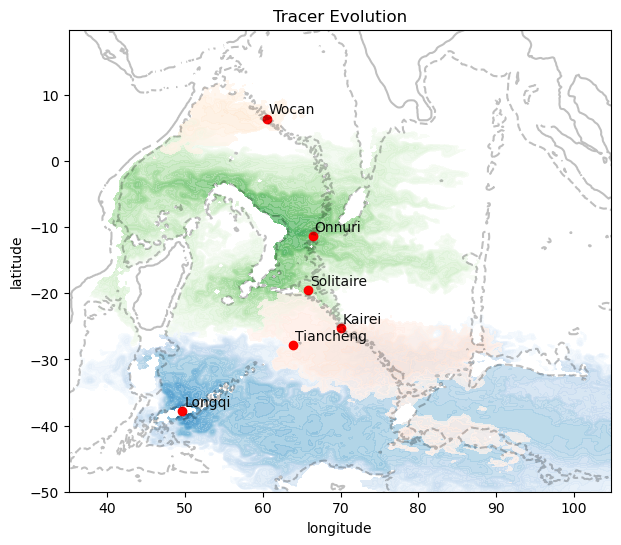

In [44]:
fig=plt.figure(figsize=(7, 6))
# use contour with 'lons' and 'lats' for the plot x and y axes
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac01.__xarray_dataarray_variable__[-3,50].values), 
             cmap='Blues',alpha=0.75,levels=np.arange(1,6.1,0.1))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac02.__xarray_dataarray_variable__[-3,50].values), 
             cmap='Greens',alpha=0.75,levels=np.arange(1,6.1,0.1))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac03.__xarray_dataarray_variable__[-3,50].values), 
             cmap='Reds',alpha=0.75,levels=np.arange(0,6.1,0.1))
plt.contourf(trac01.lon.values, trac01.lat.values,np.log10( trac04.__xarray_dataarray_variable__[-3,50].values), 
             cmap='Oranges',alpha=0.75,levels=np.arange(1,6.1,0.1))
plt.title('Tracer Evolution')

plt.xlim(np.nanmin(trac01.lon.values), np.nanmax(trac01.lon.values))
plt.ylim(np.nanmin(trac01.lat.values), np.nanmax(trac01.lat.values))

plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.colorbar()

plt.scatter(lonall, latall, c='r')
for i in range(6):
    plt.text(lonall[i]+0.25,latall[i]+0.75,site[i], alpha=0.95 )

plt.contour(topo540.lon,topo540.lat,-topo540,levels=[-3000],colors='k',alpha=0.25)
plt.contour(topo540.lon,topo540.lat,topo540,levels=[20],colors='k',alpha=0.25)


In [102]:
import imageio, os, sys
import glob
def png_gif(filename,outname):
    pnglst = sorted(glob.glob(filename))
    frames = []
    for i in pnglst:
        frames.append( imageio.v2.imread( i) )
    
    imageio.mimsave(outname, frames, 'GIF', duration=2. )


In [86]:
png_gif('tracer_*Z1914*.png','tracer_Z1914.gif')

/tmp/ipykernel_419920/3428853872.py:21: RuntimeWarning: invalid value encountered in log10
  _ = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac01.__xarray_dataarray_variable__.values[tt,kk]),
/tmp/ipykernel_419920/3428853872.py:23: RuntimeWarning: invalid value encountered in log10
  _ = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac02.__xarray_dataarray_variable__.values[tt,kk]),
/tmp/ipykernel_419920/3428853872.py:25: RuntimeWarning: invalid value encountered in log10
  _ = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac03.__xarray_dataarray_variable__.values[tt,kk]),
/tmp/ipykernel_419920/3428853872.py:27: RuntimeWarning: invalid value encountered in log10
  C = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac04.__xarray_dataarray_variable__.values[tt,kk]),


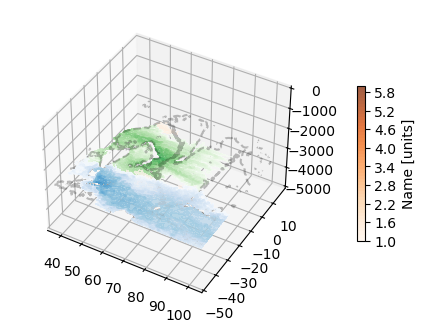

In [56]:
import matplotlib.pyplot as plt
import numpy as np

tt = 15
kk = 50

# Define dimensions
Nx, Ny, Nz = 100, 300, 500
X, Y, Z = np.meshgrid(trac01.lon, trac01.lat, trac01.Z)

# Create fake data
#data = trac01[-1]

#kw = {'vmin': data.min(),'vmax': data.max(),'levels': np.linspace(data.min(), data.max(), 10),}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac01.__xarray_dataarray_variable__.values[tt,kk]), 
             cmap='Blues',alpha=0.75,levels=np.arange(1,6.1,0.1), zdir='z', offset=-3000,)
_ = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac02.__xarray_dataarray_variable__.values[tt,kk]), 
             cmap='Greens',alpha=0.75,levels=np.arange(1,6.1,0.1), zdir='z', offset=-3000,)
_ = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac03.__xarray_dataarray_variable__.values[tt,kk]), 
             cmap='Reds',alpha=0.75,levels=np.arange(0,6.1,0.1), zdir='z', offset=-3000,)
C = ax.contourf(X[:,:,kk],Y[:,:,kk],np.log10( trac04.__xarray_dataarray_variable__.values[tt,kk]), 
             cmap='Oranges',alpha=0.75,levels=np.arange(1,6.1,0.1), zdir='z', offset=-3000,)


Xtopo, Ytopo = np.meshgrid(topo_tracer.lon, topo_tracer.lat)
ax.contour(Xtopo, Ytopo,-topo_tracer,levels=[-3000],colors='k',alpha=0.25, zdir='z', offset=-3000,)
ax.contour(Xtopo, Ytopo, topo_tracer,levels=[20],colors='k',alpha=0.25, zdir='z', offset=-3000,)


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[-5000, 0])

## Plot edges
#edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
#ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
#ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
#ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
#ax.set(xlabel='X [km]', ylabel='Y [km]', zlabel='Z [m]', zticks=[], )

# Set zoom and angle view
ax.view_init(40, -60, 0)
ax.set_box_aspect(None, zoom=0.9)

# Colorbar
fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()

In [39]:
ymin

-50.0

In [18]:
X, Y, Z = np.meshgrid(trac01.lon, trac01.lat, trac01.Z)


In [19]:
trac01

<xarray.Dataset> Size: 711MB
Dimensions:                        (time: 16, Z: 63, lat: 420, lon: 420)
Coordinates:
  * time                           (time) datetime64[ns] 128B 2088-07-02T00:0...
  * Z                              (Z) float32 252B -0.5 -1.5 ... -5.906e+03
  * lat                            (lat) float64 3kB -50.0 -49.83 ... 19.83
  * lon                            (lon) float64 3kB 35.0 35.17 ... 104.7 104.8
Data variables:
    __xarray_dataarray_variable__  (time, Z, lat, lon) float32 711MB dask.array<chunksize=(1, 63, 420, 420), meta=np.ndarray>